# Create results plots perlin vs mri experiment

In [1]:
import pandas as pd
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
plt.rc('image', cmap='gray')

from copy import deepcopy

import time, datetime 

import h5py
import pickle as pkl

from sklearn.preprocessing import minmax_scale
from sklearn.metrics import auc, classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.metrics._ranking import _binary_clf_curve

import seaborn as sns
import ptitprince as pt

from matplotlib import gridspec

In [2]:
save_fig = True

In [3]:
sns.set_style('dark')
plt.rcParams["font.size"] = "14"

In [4]:
result_dir_perlin = '/path/to/perlin/results'
result_dir_mri = '/path/to/mri/results'

data_dir_perlin = '/path/to/perlin/data'
data_dir_mri = '/path/to/mri/data'

result_dir = '/general/results/path'

name = f'overview_heatmaps_perlin_vs_mri'

## Load data

In [5]:
def open_heatmaps_scores(result_dir, data_dir):
    print(f'Opening files for {data_dir}')
    with open(os.path.join(result_dir, f'heatmaps/simple_model_best_fold.pkl'), 'rb') as f:
        dict_all_heatmaps = pkl.load(f)
    with open(os.path.join(result_dir, f'heatmaps/prediction_scores.pkl'), 'rb') as f:
        dict_all_scores = pkl.load(f)
    with open(os.path.join(data_dir, f'ground_truth_maps_holdout.pkl'), 'rb') as f:
        ground_truth = pkl.load(f)
    
    return dict_all_heatmaps, dict_all_scores, ground_truth

In [6]:
holdout_h5_perlin = h5py.File(os.path.join(data_dir_perlin, 'holdout_data.h5'), 'r')
X_holdout_perlin, y_holdout_perlin = holdout_h5_perlin['X'], holdout_h5_perlin['y']
X_holdout_perlin = np.array(X_holdout_perlin)
y_holdout_perlin = np.array(y_holdout_perlin)

In [ ]:
heatmaps_perlin, scores_perlin, ground_truth_perlin = open_heatmaps_scores(result_dir_perlin, data_dir_perlin)

In [8]:
holdout_h5_mri = h5py.File(os.path.join(data_dir_mri, 'holdout_data.h5'), 'r')
X_holdout_mri, y_holdout_mri = holdout_h5_mri['X'], holdout_h5_mri['y']
X_holdout_mri = np.array(X_holdout_mri)
y_holdout_mri = np.array(y_holdout_mri)

In [ ]:
heatmaps_mri, scores_mri, ground_truth_mri = open_heatmaps_scores(result_dir_mri, data_dir_mri)

In [10]:
ground_truths = []
for idx in range(200):
    slice_idx = idx % 135
    part_idx = int(idx/135)
    ground_truths.append(ground_truth_mri[part_idx][slice_idx][2])
ground_truth_mri = ground_truths

In [11]:
methods = ['gradient', 'deep_taylor', 'lrp.z', 'lrp.alpha_beta', 'deconvnet', 'guided_backprop', 'pattern.net', 'pattern.attribution']
methods_title_list = ['Gradient', 'DTD', 'LRP-z', 'LRP-alpha/beta', 'DeConvNet', 'Guided Backprop', 'PatternNet', 'PatternAttribution']

In [12]:
labels = y_holdout_mri[:200]
list_idx_pos = [i for i in range(200) if labels[i] == 1]
list_idx_neg = [i for i in range(200) if labels[i] == 0]
all_idx = np.arange(len(labels))

In [13]:
def explanation_to_heatmap(e):
    tmp = (e/np.max(np.abs(e))) * 127.5 + 127.5
    colormap = plt.cm.get_cmap("seismic")
    tmp = colormap(tmp.flatten().astype(np.int64))[: , :3]
    tmp = tmp.reshape((e.shape[0], e.shape[1], 3)) 
    return tmp

def explanation_to_projection(e):
    # To range [0, 1]
    return (np.abs(e)/np.max(np.abs(e)))

def explanation_to_graymap(e):
    # Reduce color axis
    # To range [0, 255]
    tmp = ( e / np.max(np.abs(e))) * 255

    # Create and apply red - blue heatmap
    colormap = plt.cm.get_cmap("gray")

    tmp = colormap(tmp.flatten().astype(np.int64 ))[: , :3]
    tmp = tmp.reshape((e.shape[0], e.shape[1], 3))
    return tmp

## Generate results plot for set indices

In [14]:
indices = [91, 89]

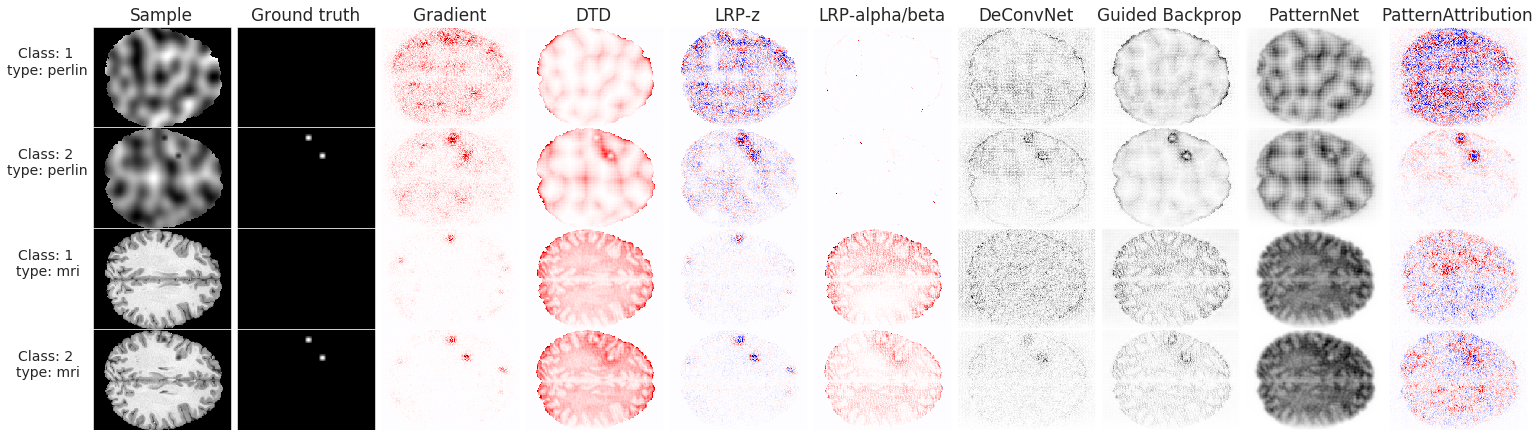

In [15]:
nrow = len(indices) * 2
ncol = len(methods) + 2

fig = plt.figure(figsize = (2 * (ncol + 1), 2 * (nrow) - 1))

gs = gridspec.GridSpec(nrow, ncol,
         wspace=0.0, hspace=0.0, 
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
         left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 

k = 0
for i in range(4): 
    if i == 0: 
        X_holdout, y_holdout = X_holdout_perlin, y_holdout_perlin
        ground_truth = ground_truth_perlin
        heatmaps = heatmaps_perlin
        prediction_scores = scores_perlin
        idx = indices[0]
        background = 'perlin'
        
    elif i == 1: 
        X_holdout, y_holdout = X_holdout_perlin, y_holdout_mri
        ground_truth = ground_truth_perlin
        heatmaps = heatmaps_perlin
        prediction_scores = scores_perlin
        idx = indices[1]
        background = 'perlin'
        
    elif i == 2: 
        X_holdout, y_holdout = X_holdout_mri, y_holdout_mri
        ground_truth = ground_truth_mri
        heatmaps = heatmaps_mri
        prediction_scores = scores_mri
        idx = indices[0]
        background = 'mri'

    else: 
        X_holdout, y_holdout = X_holdout_mri, y_holdout_mri
        ground_truth = ground_truth_mri
        heatmaps = heatmaps_mri
        prediction_scores = scores_mri
        idx = indices[1]
        background = 'mri'
        
    softmax_scores = [prediction_scores['gradient'][i][0] for i in range(len(prediction_scores['gradient']))]
    softmax_output = np.array([i.max() for i in softmax_scores])
    pred_labels = np.array([prediction_scores['gradient'][i][2] for i in range(len(prediction_scores['gradient']))])
        
    for j in range(len(methods) + 2): 
        ax = plt.subplot(gs[i, j])
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
        
        if j % (2 + len(methods)) == 0:
            cmap = 'gist_gray'
            ax.imshow(X_holdout[idx], cmap)
            label = y_holdout[idx]
            ax.set_ylabel(f'Class: {int(label + 1)} \ntype: {background}', fontsize = 14, rotation = 0, labelpad = 45, ha = 'center')
            if k == 0:
                ax.set_title(f'Sample')
            
        elif j % (2 + len(methods)) == 1:
            cmap = 'gist_gray'
            ax.imshow(ground_truth[idx], cmap)
            if k == 0: 
                ax.set_title('Ground truth')
            
        else: 
            method = methods[j - 2]
            method_title = methods_title_list[j-2]
            heatmap = heatmaps[method][idx].reshape(heatmaps[method][idx].shape[1], heatmaps[method][idx].shape[2])
            if method == 'pattern.net' or method == 'deconvnet' or method == 'guided_backprop': 
                heatmap = explanation_to_projection(heatmap)
                cmap = 'binary'
            elif method == 'gradient': 
                heatmap = explanation_to_heatmap(np.abs(heatmap))
            else: 
                heatmap = explanation_to_heatmap(heatmap)
            ax.imshow(heatmap, cmap)

            if k == 0: 
                ax.set_title(f'{method_title}')
        
    k += 2 + len(methods)
        
# plt.tight_layout()

if save_fig is True: 
    output_path = f'overview_result_plot_medneurips_perlin_mri.pdf'
    fig.savefig(os.path.join(result_dir, output_path), orientation='landscape', dpi=300, bbox_inches = 'tight')

In [16]:
quit()